In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import torch
import re
from tqdm.notebook import tqdm
import sys

print(torch.__version__)
print(torch.cuda.is_available())
src_path = Path('.').absolute().parent
data_path = src_path / 'data'
sys.path.append(str(src_path / 'src'))

import yaml
import networkx as nx
from ontology import OntologySystem

with (src_path / 'setting_files' / 'app_settings.yml').open('r') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

onto = OntologySystem(
    acc_name_path=data_path / 'AccountName.csv', 
    rdf_path=data_path / 'AccountRDF.xml',
    model_path=data_path / settings['ontology']['model']['model_name'],
    kwargs_graph_drawer=settings['ontology']['graph_drawer']
)
ACC_DICT = onto.ACC_DICT

1.10.1
True


---

# Create dataset

In [26]:
# TODO: position 만들기
# ("I was driving a BMW", {"entities": [(16,19, "PRODUCT")]})

def get_entity(s, x, tag):
    idx = s.index(x)
    return (idx, idx+len(x), tag)

def random_sampling(x_dict, x_key):
    idx_range = np.arange(len(x_dict[x_key]))
    idx = np.random.choice(idx_range, replace=False, p=np.ones(len(idx_range)) / len(idx_range))
    word, tag, desc = x_dict[x_key][idx]
    return word, tag, desc

def get_words_filtered(words, text):
    words_filtered = defaultdict(list)
    for k, v in words.items():
        for word, tag, desc in v:
            if desc != text:
                words_filtered[k].append((word, tag, desc))
    return words_filtered

df = pd.read_csv(data_path / 'AccountWords.csv', encoding='utf-8')

format_dict = {
    0: ['help'],
    1: [
        # what/how, target_account, [MASK] + year/quarter
        "{} is the {} in the {} ?",
        # [MASK] + year/quarter, what/how, target_account
        "In the {}, {} is the value of the {} ?"
    ], 
    2: [
        # target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
        "what happens to the {} when the {} {} by {} in the {} ?",
        # target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
        "what will be the effect to {} if the {} {} by {} in the {} ?",
        # reverse the relation
        # subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
        "when the {} {} by {} in the {}, what will happen to the {} ?",
        # subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
        "if the {} {} by {} in the {}, what will be the effect to {} ?"
    ],
    3: [
        # what/how, target_account, [MASK] + year/quarter
        "{} will be the {} in the {} ?"
    ]
}

# TODO: maybe add the today's information after [SEP]?
context = ['HELP', 'PAST', 'FUTURE']
words = defaultdict(list)
for typ in ['year', 'quarter', 'words']:
    df_temp = df.loc[:, [typ, f'{typ}_tag', f'{typ}_desc']]
    df_temp = df_temp.loc[~df_temp[typ].isna(), :]
    for i, (w, t, desc) in df_temp.iterrows():
        words[typ].append((w, t, desc))

exceptions = ['BalanceSheet', 'IncomeStatement', 'Ratios', 'CalendarOneYear']
times = ['year', 'quarter']

all_data = []
s_ENT = '[E]'
e_ENT = '[/E]'
f_ENT = lambda x: f'{s_ENT}{x}{e_ENT}'


## Question 1

```python
# what/how, target_account, [MASK] + year/quarter
"{} is the {} in the {}?",
```

In [104]:
data1 = []
trg_scenario = 1
progress_bar = tqdm()
words_filtered = get_words_filtered(words, text='FUTURE')
for idx_fmt, fmt in enumerate(format_dict[trg_scenario]):
    
    for acc, dic in ACC_DICT.items():
        if acc in exceptions:
            continue
        target_account = dic['eng_name'].lower()
        knowledge, acc_type, _ = dic['group'].split('-')

        for t in ['year', 'quarter']:
            for t_word, t_tag, _ in words_filtered[t]:
                entities = []
                pre_token = np.random.choice(['what', 'how'], replace=False, p=np.ones(2)/2)
                if idx_fmt == 0:
                    # what/how, target_account, [MASK] + year/quarter
                    # "{} is the {} in the {}?",
                    s = fmt.format(
                        pre_token,
                        f_ENT(target_account), 
                        f_ENT(f'{t_word} {t}')
                        )
                else:
                    # [MASK] + year/quarter, what/how, target_account
                    # "In the {}, {} is the value of the {}"
                    s = fmt.format(
                        f_ENT(f'{t_word} {t}'),
                        pre_token,
                        f_ENT(target_account)
                    )
                # relation = [0, 0, 0]  # no_relation, order1, order2
                # entities
                ## target_account
                entities.append(get_entity(s, f_ENT(target_account), f'{knowledge}.{acc_type}'))
                ## MASK year/quarter
                entities.append(get_entity(s, f_ENT(f'{t_word} {t}'), t_tag))
                
                data1.append(
                    {'question': s, 'entities': sorted(entities, key=lambda x: x[0]), 'intent': 'PAST.value'} #, 'relation': relation}
                )
            
                progress_bar.update(1)

0it [00:00, ?it/s]

## Question 2

```python
# target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
"what happens to the {} when the {} {} by {} in the {}?"
# target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
"what will be the effect to {} if the {} {} by {} in the {}?"
# reverse the relation
# subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
"when the {} {} by {} in the {}, what will happen to the {}?"
# subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
"if the {} {} by {} in the {}, what will be the effect to {}?"
```

In [106]:
def get_role_dict(onto, knowledge):
    knowledge_query = onto.sparql.get_predefined_knowledge(knowledge=knowledge)
    sparql_results = onto.sparql.query(knowledge_query)
    role_dict = defaultdict(list)
    for s, p, o in sparql_results:
        s, p, o = map(onto.graph_drawer.convert_to_string, [s, p, o])
        if s == 'CalendarOneYear' or o == 'CalendarOneYear':
            continue
        if s not in role_dict[o]:
            role_dict[o].append(s)
        
    return role_dict

def process_successor(successors, role_dict, trg_acc, acc):
    if role_dict.get(acc) is None:
        # successors[trg_acc].extend(successors[acc])
        return None
    else:
        accs = role_dict.get(acc)
        if accs is not None:
            successors[trg_acc].extend(accs)
            for acc in accs:
                process_successor(successors, role_dict, trg_acc, acc)

def get_successor(onto, knowledge, exceptions=None):
    role_dict = get_role_dict(onto, knowledge=knowledge)
    successors = defaultdict(list)
    for trg_acc in role_dict.keys():
        if (exceptions is not None) and (trg_acc in exceptions):
            continue
        process_successor(successors, role_dict, trg_acc, trg_acc)
    return successors

trg_scenario = 2
bs_successors = get_successor(sparql, 'BS', exceptions)
is_successors = get_successor(sparql, 'IS', exceptions)
data2 = []
n_sample = 5
progress_bar = tqdm()
words_filtered = get_words_filtered(words, text='FUTURE')

for idx_fmt, fmt in enumerate(format_dict[trg_scenario]):
    for sub_tree in [bs_successors, is_successors]:
        for trg_acc, successors in sub_tree.items():
            if trg_acc in exceptions:
                continue
            target_account = ACC_DICT[trg_acc]['eng_name'].lower()
            target_knowledge, target_acc_type, _ = ACC_DICT[trg_acc]['group'].split('-')
            for sub_acc in successors:
                subject_account = ACC_DICT[sub_acc]['eng_name'].lower()
                subject_knowledge, subject_acc_type, _ = ACC_DICT[trg_acc]['group'].split('-')
                n = 0
                while n < n_sample:
                    entities = []

                    apply_word, apply_tag, _ = random_sampling(x_dict=words_filtered, x_key='words')
                    t = np.random.choice(times, replace=False, p=np.ones(len(times))/len(times))
                    t_word, t_tag, _ = random_sampling(x_dict=words_filtered, x_key=t)
                    
                    number = np.random.randint(1, 99)
                    percent = np.random.choice(['percent', '%'], replace=False, p=np.ones(2)/2)
                    
                    if idx_fmt in [0, 1]:
                        # target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
                        s = fmt.format(
                            f_ENT(target_account),
                            f_ENT(subject_account), 
                            f_ENT(apply_word), 
                            f_ENT(f'{number} {percent}'),
                            f_ENT(f'{t_word} {t}')
                            )
                        # relation = [1, 1, 2]
                    else:
                        # subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
                        s = fmt.format(
                            f_ENT(subject_account), 
                            f_ENT(apply_word), 
                            f_ENT(f'{number} {percent}'),
                            f_ENT(f'{t_word} {t}'),
                            f_ENT(target_account)
                            )
                        # relation = [1, 2, 1]
                    # entities
                    ## target_account
                    entities.append(get_entity(s, f_ENT(target_account), f'{target_knowledge}.{target_acc_type}'))
                    ## subject_account
                    entities.append(get_entity(s, f_ENT(subject_account), f'{subject_knowledge}.{subject_acc_type}'))
                    ## MASK apply words
                    entities.append(get_entity(s, f_ENT(apply_word), apply_tag))
                    ## percentages
                    entities.append(get_entity(s, f_ENT(f'{number} {percent}'), 'PERCENT'))
                    ## MASK year/quarter
                    entities.append(get_entity(s, f_ENT(f'{t_word} {t}'), t_tag))

                    d = {'question': s, 'entities': sorted(entities, key=lambda x: x[0]), 'intent': 'IF.fact'} #, 'relation': relation}
                    if d not in data2:
                        data2.append(
                            d
                        )
                    
                    progress_bar.update(1)
                    n += 1

## Question 3

```python
# what/how, target_account, [MASK] + year/quarter
"{} will be the {} in the {}?"
```

In [109]:
data3 = []
trg_scenario = 3
progress_bar = tqdm()
words_filtered = get_words_filtered(words, text='PAST')

for fmt in format_dict[trg_scenario]:
    for acc, dic in ACC_DICT.items():
        if acc in exceptions:
            continue
        target_account = dic['eng_name'].lower()
        knowledge, acc_type, _ = dic['group'].split('-')
        for t in ['year', 'quarter']:
            for t_word, t_tag, _ in words_filtered[t]:
                entities = []
                s = fmt.format(
                    np.random.choice(['what', 'how']), 
                    f_ENT(target_account), 
                    f_ENT(f'{t_word} {t}')
                    )
                # relation = [0, 0, 0]
                # entities
                ## target_account
                entities.append(get_entity(s, f_ENT(target_account), f'{knowledge}.{acc_type}'))
                ## MASK year/quarter
                entities.append(get_entity(s, f_ENT(f'{t_word} {t}'), t_tag))
                
                data3.append(
                    {'question': s, 'entities': entities, 'intent': 'IF.forecast'} #, 'relation': relation}
                )
                
                progress_bar.update(1)

all_data = data1 + data2 + data3

0it [00:00, ?it/s]

1014


---

# Post-process for entities

In [ ]:
import json

special_len = len(s_ENT)+len(e_ENT)

for k, x in tqdm(enumerate(all_data), total=len(all_data)):
    all_data[k]['question'] = x['question'].replace(s_ENT, '').replace(e_ENT, '')
    for i, (s, e, ent) in enumerate(x['entities']):
        new_s = s-i*special_len
        new_e = new_s+(e-s)-special_len
        all_data[k]['entities'][i] = (new_s, new_e, ent)

with (data_path / 'all_data.jsonl').open('w', encoding='utf-8') as file:
    for line in tqdm(all_data, total=len(all_data), desc='saving'):
        file.write(json.dumps(line) + '\n')

---

# Traning

- Entities
- Entities Relation (subject, target)

## Dataset

In [2]:
from src.nlu_utils import NLUDataModule, NLUTokenizer, NLUDataset

main_path = Path().absolute().parent
data_path = main_path / 'data'
setting_path = main_path / 'setting_files'

with (setting_path / 'train_settings.yml').open('r') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

nlu_tokenizer = NLUTokenizer()

data_module = NLUDataModule(
    train_path=data_path / settings['train_file'], 
    valid_path=data_path / settings['valid_file'],
    test_path=data_path / settings['test_file'],
    labels_path=data_path / settings['labels_file'],
    batch_size=settings['batch_size'], 
    max_len=settings['max_len'],
    num_workers=settings['num_workers'],
    seed=settings['seed']
)
data_module.prepare_data()

ModuleNotFoundError: No module named 'src'

---

In [29]:
train_data = data_module.train_data
train_dataset = NLUDataset(
    train_data, 
    tags2id=data_module.tags2id, 
    intents2id=data_module.intents2id,
)
train_dataloader = data_module.train_dataloader()

In [30]:
for x in train_dataloader:
    break

In [36]:
x['tags'][-1]

tensor([ 0,  0,  0,  0,  0,  3,  0,  0, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [33]:
from collections import Counter

c = Counter()
for l in x['tags']:
    c.update(l.tolist())

In [4]:
from datasets import load_dataset
conll = load_dataset('conll2003')

Reusing dataset conll2003 (C:\Users\simon\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)
100%|██████████| 3/3 [00:00<00:00, 430.13it/s]


In [5]:
dataset = conll['train']
feature = dataset.features['ner_tags'].feature
errors = 0
x = dataset[1343]
text = ' '.join(x['tokens']).lower()
doc = nlu_tokenizer.spacy_nlp(text)

In [6]:
doc
spacy_tokens = list(map(str, doc))
tags = list(map(feature.int2str, x['ner_tags']))
bert_tokens = nlu_tokenizer.bert_tokenize(text)
original_tokens = list(map(str.lower, x['tokens']))

print(original_tokens)
print(tags)
print(spacy_tokens)
print(bert_tokens)
print(list(map(len, [original_tokens, tags, spacy_tokens, bert_tokens])))

['a', 'west', 'bank', 'bookseller', 'charged', 'on', 'thursday', 'that', 'the', 'palestinian', 'information', 'ministry', 'has', 'forced', 'him', 'to', 'sign', 'an', 'undertaking', 'not', 'to', 'distribute', 'books', 'written', 'by', 'critics', 'of', 'israeli-plo', 'self-rule', 'deals', '.']
['O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O']
['a', 'west', 'bank', 'bookseller', 'charged', 'on', 'thursday', 'that', 'the', 'palestinian', 'information', 'ministry', 'has', 'forced', 'him', 'to', 'sign', 'an', 'undertaking', 'not', 'to', 'distribute', 'books', 'written', 'by', 'critics', 'of', 'israeli', '-', 'plo', 'self', '-', 'rule', 'deals', '.']
['a', 'west', 'bank', 'books', '##eller', 'charged', 'on', 'thursday', 'that', 'the', 'palestinian', 'information', 'ministry', 'has', 'forced', 'him', 'to', 'sign', 'an', 'undertaking', 'not', 'to', 'distribute', 'bo

In [9]:
from tokenizations import get_alignments
from spacy.training import biluo_tags_to_offsets, iob_to_biluo, biluo_to_iob

In [60]:
print(mapped_tags)

['O', 'B-LOC', 'L-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'L-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'L-MISC', 'O', 'O', 'O', 'O', 'O']


In [62]:
entities = biluo_tags_to_offsets(doc, mapped_tags)
entities

[(2, 11, 'LOC'), (52, 84, 'ORG'), (169, 180, 'MISC')]

In [ ]:
typ = 'train'
dataset = conll[typ]
feature = dataset.features['ner_tags'].feature
errors = 0
for x in tqdm(dataset, total=len(dataset), desc=f'{typ}set'):
    text = ' '.join(x['tokens']).lower()
    doc = nlu_tokenizer.spacy_nlp(text)

    tags = list(map(feature.int2str, x['ner_tags']))
    spacy_tokens = list(map(str, doc))
    original_tokens = list(map(str.lower, x['tokens']))
    mapped_tags = nlu_tokenizer.fix_tags_alignment(
        longer_tokens=spacy_tokens, shorter_tokens=original_tokens, tags=tags
    )

    entities = biluo_tags_to_offsets(doc, mapped_tags)
    if not entities:
        errors += 1
        continue

    d = {'text': text, 'entities': entities, 'intent': 'None'}

In [ ]:
print(original_tokens)
print(tags)
print(spacy_tokens)
print(mapped_tags)

In [10]:
a2b, b2a = get_alignments(a=original_tokens, b=spacy_tokens)

biluo_tags = iob_to_biluo(tags)
mapped_tags = ['-'] * len(spacy_tokens)
for i, tag in enumerate(biluo_tags):
    if tag == 'O':
        for k in a2b[i]:
            mapped_tags[k] = tag
        continue

    prefix, label = tag.split('-')
    if prefix == 'B':
        for j, k in enumerate(a2b[i]):
            if j == 0:
                mapped_tags[k] = tag
            else:
                mapped_tags[k] = f'I-{label}'
    elif prefix == 'L':
        for j, k in enumerate(a2b[i]):
            if j == len(a2b[i])-1:
                mapped_tags[k] = tag
            else:
                mapped_tags[k] = f'I-{label}'
    elif prefix == 'U':
        if len(a2b[i]) == 1:
            k = a2b[i][0]
            mapped_tags[k] = tag
        elif len(a2b[i]) == 2:
            b, l = a2b[i]
            mapped_tags[b] = f'B-{label}'
            mapped_tags[l] = f'L-{label}'
        else:
            for j, k in enumerate(a2b[i]):
                if j == 0:
                    mapped_tags[k] = f'B-{label}'
                elif j == len(a2b[i])-1:
                    mapped_tags[k] = f'L-{label}'
                else:
                    mapped_tags[k] = f'I-{label}'
    else:
        for j, k in enumerate(a2b[i]):
            mapped_tags[k] = tag

# TODO: augmentation 구현하기

In [28]:
from transformers import pipeline
from spacy.training import biluo_tags_to_offsets, iob_to_biluo, offsets_to_biluo_tags, biluo_to_iob
from src.nlu_createData import SparqlHandler

s_ENT = '[E]'
e_ENT = '[/E]'
f_ENT = lambda x: f'{s_ENT}{x}{e_ENT}'
def get_entity(s, x, tag):
    idx = s.index(x)
    return (idx, idx+len(x), tag)

sparql = SparqlHandler(data_path / 'AccountRDF.xml')
df_account = pd.read_csv(data_path / 'AccountName.csv', encoding='utf-8')
ACC_DICT = defaultdict(dict)
for _, row in df_account.iterrows():
    acc = row['acc']
    eng = row['acc_name_eng']
    kor = row['acc_name_kor']
    group = row['group']
    ACC_DICT[acc]['kor_name'] = kor
    ACC_DICT[acc]['eng_name'] = eng
    ACC_DICT[acc]['group'] = group

df = pd.read_csv(data_path / 'AccountWords.csv', encoding='utf-8')

format_dict = {
    0: [
        # only to train the ner task
        # account 
    ],
    1: [
        # what/how, target_account, [MASK] + year/quarter
        "{} is the {} in the {}?",
    ], 
    2: [
        # target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
        "what happens to the {} when the {} {} by {} in the {}?",
        # target_account, subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter
        "what will be the effect to {} if the {} {} by {} in the {}?",
        # reverse the relation
        # subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
        "when the {} {} by {} in the {}, what will happen to the {}?",
        # subject_account, [MASK], random_number + percent/%, [MASK] + year/quarter, target_account
        "if the {} {} by {} in the {}, what will be the effect to {}?"
    ],
    3: [
        # what/how, target_account, [MASK] + year/quarter
        "{} will be the {} in the {}?"
    ]
}

In [3]:
# model_p = 'bert-base-uncased' # 'albert-base-v2' / 'bert-base-uncased'
# fillmask = pipeline('fill-mask', model=model_p)
# generator = pipeline('text-generation', model='gpt2')
# mask_token = fillmask.tokenizer.mask_token

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# generator(f'{target_account}', max_length=50, num_return_sequences=5)

In [29]:
import torch
from copy import deepcopy
from transformers import AutoTokenizer, AutoModelForMaskedLM
# , BertTokenizerFast, BertForMaskedLM, AlbertForMaskedLM, AlbertTokenizerFast

# model_p = 'bert-base-uncased' # 'albert-base-v2' / 'bert-base-uncased'
# fillmask = pipeline('fill-mask', model=model_p)
# generator = pipeline('text-generation', model='gpt2')
# mask_token = fillmask.tokenizer.mask_token

In [31]:
def fill_multi_mask(bert_model, tokenizer, text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = bert_model(**inputs)
    predictions = outputs[0]
    return predictions

def template_generator(mask_token, max_length, acc_idxes, target_account):
    preset = [mask_token] * max_length
    candidates = []
    for i in acc_idxes:
        temp = deepcopy(preset)
        temp[i] = target_account
        candidates.append(' '.join(temp))
    return candidates

def get_aug_sequences(tokenizer, model, cands, top_k, max_length):
    number_of_mask_token = max_length-1
    m_l = 0
    while m_l < number_of_mask_token:
        cands_tokens = [tokenizer.tokenize(c, padding=True, truncation=True) for c in cands]
        infer_indices = []
        for c in cands_tokens:
            mask_idx = list(np.arange(len(c))[np.array(c) == '[MASK]'])
            choosed_idx = np.random.choice(mask_idx)
            infer_indices.append(choosed_idx)
        
        inputs = tokenizer(cands, padding=True, truncation=True, return_tensors='pt')
        o = model(**inputs)[0][:, 1:-1]
        _, sorted_idx = o.sort(dim=-1, descending=True)
        predict_ids = sorted_idx[torch.arange(sorted_idx.size(0)), infer_indices, :top_k]

        cands_tensors = inputs['input_ids'][:, 1:-1]
        cands_tensors = cands_tensors.unsqueeze(1).expand(cands_tensors.size(0), top_k, cands_tensors.size(1)).clone()
        cands_tensors[torch.arange(cands_tensors.size(0)), :, infer_indices] = predict_ids
        cands = [tokenizer.decode(c) for c in cands_tensors.view(cands_tensors.size(0)*top_k, -1)]
        m_l += 1
    cands = [c.replace(tokenizer.pad_token, '').strip() for c in cands]
    return cands

In [30]:
model_dict = dict(
    enumerate([
    'bert-base-uncased',  # 0
    'albert-base-v2',  # 1
    'roberta-base',  # 2
    'google/electra-base-generator'  # 3
    ])
)
model_path = model_dict[3]
model = AutoModelForMaskedLM.from_pretrained(model_path)  # albert_model / bert_model
tokenizer = AutoTokenizer.from_pretrained(model_path)  # albert_tokenizer / bert_tokenizer
# fillmask = pipeline('fill-mask', model=model_path)
# generator = pipeline('text-generation', model='gpt2')
# mask_token = fillmask.tokenizer.mask_token

In [33]:
class DataCreator:
    s_ENT = '[E]'
    e_ENT = '[/E]'
    # f_ENT = lambda x: f'[E]{x}[/E]'

    def __init__(self, data_path, template_token_lengths=10, top_k=5, model_idx=3, simple_knowledge_tag=True):
        self.data_path = data_path
        self.exceptions = ['BalanceSheet', 'IncomeStatement', 'Ratios', 'CalendarOneYear']
        self.times = ['year', 'quarter']
        self.template_token_lengths = template_token_lengths
        self.top_k = top_k
        self.model_idx = model_idx
        self.simple_knowledge_tag = simple_knowledge_tag
        self.set_sparql()

        self.f_ENT = lambda x: f'{self.s_ENT}{x}{self.e_ENT}'
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.progress_bar = tqdm()

    def set_sparql(self):
        self.sparql = SparqlHandler(self.data_path / 'AccountRDF.xml')

        df_account = pd.read_csv(self.data_path / 'AccountName.csv', encoding='utf-8')
        self.ACC_DICT = defaultdict(dict)
        for _, row in df_account.iterrows():
            acc = row['acc']
            eng = row['acc_name_eng']
            kor = row['acc_name_kor']
            group = row['group']
            self.ACC_DICT[acc]['kor_name'] = kor
            self.ACC_DICT[acc]['eng_name'] = eng
            self.ACC_DICT[acc]['group'] = group

ds = DataCreator(data_path)

0it [00:00, ?it/s]

In [39]:
ds.ACC_DICT.items()

dict_items([('CurrentAssets', {'kor_name': '유동자산', 'eng_name': 'Current Assets', 'group': 'BS-Value-3'}), ('CashAndCashEquivalents', {'kor_name': '현금및현금성자산', 'eng_name': 'Cash and Cash Equivalents', 'group': 'BS-Value-4'}), ('TradeAndOtherCurrentReceivables', {'kor_name': '매출채권', 'eng_name': 'Trade and Other Current Receivables', 'group': 'BS-Value-4'}), ('PrepaidExpenses', {'kor_name': '선급비용', 'eng_name': 'Prepaid Expenses', 'group': 'BS-Value-4'}), ('Inventories', {'kor_name': '재고자산', 'eng_name': 'Inventories', 'group': 'BS-Value-4'}), ('NoncurrentAssets', {'kor_name': '비유동자산', 'eng_name': 'Noncurrent Assets', 'group': 'BS-Value-3'}), ('PropertyPlantAndEquipment', {'kor_name': '유형자산', 'eng_name': 'Property Plant and Equipment', 'group': 'BS-Value-4'}), ('IntangibleAssets', {'kor_name': '무형자산', 'eng_name': 'Intangible Assets', 'group': 'BS-Value-4'}), ('AssetsAbstract', {'kor_name': '자산총계', 'eng_name': 'Assets', 'group': 'BS-Value-1'}), ('CurrentLiabilities', {'kor_name': '유동부채', 'eng

In [10]:
template_token_lengths = 4
top_k = 5
exceptions = ['BalanceSheet', 'IncomeStatement', 'Ratios', 'CalendarOneYear']
data0 = []
progress_bar = tqdm()

model_dict = dict(
    enumerate([
    'bert-base-uncased',  # 0
    'albert-base-v2',  # 1
    'roberta-base',  # 2
    'google/electra-base-generator'  # 3
    ])
)
model_path = model_dict[3]
model = AutoModelForMaskedLM.from_pretrained(model_path)  # albert_model / bert_model
tokenizer = AutoTokenizer.from_pretrained(model_path)  # albert_tokenizer / bert_tokenizer

for acc, dic in ACC_DICT.items():
    if acc in exceptions:
        continue
    target_account = dic['eng_name'].lower()
    knowledge, acc_type, _ = dic['group'].split('-')
    target_entitiy = f'{knowledge}'
    for l in range(1, template_token_lengths+1):
        progress_bar.set_description(f'{target_account}, {target_entitiy}: length-{l}')

        if l == 1:
            # skip fill mask
            sentences = [f_ENT(target_account)]
        else:
            # fill mask
            acc_idxes = np.random.choice(range(l), size=(l,), replace=False)

            cands = template_generator(
                mask_token=mask_token, 
                max_length=l,
                acc_idxes=acc_idxes,
                target_account=target_account
            )
            sentences = get_aug_sequences(
                tokenizer=tokenizer, 
                model=model, 
                cands=cands, 
                top_k=top_k, 
                max_length=l
            )
            sentences = [f'{f_ENT(target_account)}'.join(aug_sent.split(target_account)) for aug_sent in sentences]
        for s in sentences:
            entities = []
            entities.append(get_entity(s, f_ENT(target_account), target_entitiy))
            data0.append(
                {'text': s, 'entities': sorted(entities, key=lambda x: x[0]), 'intent': 'None'} 
            )
            progress_bar.update(1)
        
        if l == 3:
            break
    break 

0it [00:00, ?it/s]

NameError: name 'f_ENT' is not defined

In [48]:
l = 4
acc_idxes = np.random.choice(range(l), size=(l,), replace=False)

def template_generator(mask_token, max_length, acc_idxes, target_account):
    preset = [mask_token] * max_length
    candidates = []
    for i in acc_idxes:
        temp = deepcopy(preset)
        temp[i] = target_account
        candidates.append(' '.join(temp))
    return candidates

cands = template_generator(
    mask_token=mask_token, 
    max_length=l,
    acc_idxes=acc_idxes,
    target_account=target_account
)

max_length = l
number_of_mask_token = max_length-1
m_l = 0
while m_l < number_of_mask_token:
    cands_tokens = [tokenizer.tokenize(c, truncation=True) for c in cands]
    infer_indices = []
    for c in cands_tokens:
        mask_idx = list(np.arange(len(c))[np.array(c) == '[MASK]'])
        choosed_idx = np.random.choice(mask_idx)
        infer_indices.append(choosed_idx)
    
    inputs = tokenizer(cands, return_tensors='pt')
    o = model(**inputs)[0][:, 1:-1]
    _, sorted_idx = o.sort(dim=-1, descending=True)
    predict_ids = sorted_idx[torch.arange(sorted_idx.size(0)), infer_indices, :top_k]

    cands_tensors = inputs['input_ids'][:, 1:-1]
    cands_tensors = cands_tensors.unsqueeze(1).expand(cands_tensors.size(0), top_k, cands_tensors.size(1)).clone()
    cands_tensors[torch.arange(cands_tensors.size(0)), :, infer_indices] = predict_ids
    cands = [tokenizer.decode(c) for c in cands_tensors.view(cands_tensors.size(0)*top_k, -1)]
    if m_l == max_length-3:
        break
    m_l += 1

In [52]:
inputs['input_ids'].size()

torch.Size([20, 7])

In [53]:
ds = TensorDataset(inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'])

In [74]:
batch_size = 3
batch_cands = []
for i, x in enumerate(DataLoader(ds, batch_size=batch_size)):
    batch_infer_indices = infer_indices[(i*batch_size):((i+1)*batch_size)]
    o = model(input_ids=x[0], token_type_ids=x[1], attention_mask=x[2])[0][:, 1:-1]
    _, sorted_idx = o.sort(dim=-1, descending=True)
    predict_ids = sorted_idx[torch.arange(sorted_idx.size(0)), batch_infer_indices, :top_k]

    cands_tensors = x[0][:, 1:-1]
    cands_tensors = cands_tensors.unsqueeze(1).expand(cands_tensors.size(0), top_k, cands_tensors.size(1)).clone()
    cands_tensors[torch.arange(cands_tensors.size(0)), :, batch_infer_indices] = predict_ids
    batch_cands.extend([tokenizer.decode(c) for c in cands_tensors.view(cands_tensors.size(0)*top_k, -1)])


In [75]:
len(batch_cands)

100

In [72]:
infer_indices

[2, 1, 2, 2, 2, 4, 4, 1, 1, 4, 4, 3, 3, 3, 3, 4, 4, 2, 2, 2]

In [24]:
def remapping(text, ents):
    splitted = []
    text_copy = text[:]
    e_prev = 0
    for s, e, _ in ents:
        new_s = s-e_prev
        new_e = e-e_prev
        splitted.append(text_copy[:new_s])
        splitted.append(f_ENT(text_copy[new_s:new_e]))
        text_copy = text_copy[new_e:]
        e_prev = e
    new_text = ''.join(splitted)
    return new_text

remapped_text = remapping(text, ents)
remapped_text

'what happens to the [E]sales and selling general administrative ratio[/E] when the [E]cost of sales ratio[/E] [E]decreases[/E] by [E]17 %[/E] in the [E]first quarter[/E]'

In [4]:
from torch.utils.data import DataLoader, TensorDataset

In [25]:
bert_tokens = nlu_tokenizer.bert_tokenize(remapped_text)

bert_offset_mapping = nlu_tokenizer.bert(remapped_text, add_special_tokens=True, return_offsets_mapping=True)['offset_mapping']
tags = nlu_tokenizer.offset_mapping_to_tags(offset_mapping=bert_offset_mapping, ents=ents)
tags = biluo_to_iob(tags)

5


ValueError: Some Tokens are not properly assigned['O', 'O', 'O', 'O', 'O', '-', '-', '-', '-', '-', '-', '-', 'O', '-', '-', '-', '-', '-', '-', '-', 'O', '-', '-', '-', '-', '-', '-', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [15]:
masks = [i for i, t in enumerate(tags) if t == 'O']
masks

[0, 1, 2, 3, 10, 11, 17, 20, 21, 24]

In [16]:
K = np.random.choice(masks)
print(K)
masked_sentence = " ".join(bert_tokens[:K] + [mask_token] + bert_tokens[K+1:])
predictions = fillmask(masked_sentence)
augmented_sequences = [predictions[i]['sequence'] for i in range(3) if predictions[i]['sequence'] != text]
for aug_s in augmented_sequences:
    nlu_tokenizer.bert_tokenize(aug_s)
augmented_sequences

17


['what happens to the sales and selling general administrative ratio when the cost of sales ratio decreases below 17 % in the first quarter?',
 'what happens to the sales and selling general administrative ratio when the cost of sales ratio decreases to 17 % in the first quarter?']

In [55]:
bert_offset_mapping = nlu_tokenizer.bert(text, add_special_tokens=False, return_offsets_mapping=True)['offset_mapping']
bert_tokens = nlu_tokenizer.bert_tokenize(text) 

In [24]:
spacy_tokens = nlu_tokenizer.spacy_tokenize(text)
bert_encodes = nlu_tokenizer.bert(text, add_special_tokens=False, return_offsets_mapping=True)
bert_offset_mapping = bert_encodes['offset_mapping']
# bert_tokens = [nlu_tokenizer.bert_decode([i]) for i in bert_encodes['input_ids']]
bert_tokens = nlu_tokenizer.bert_tokenize(text) 

In [70]:
spacy_tokens, bert_tokens

(['was', "n't"], ['wasn', "'", 't'])

# dataloader validation check

In [9]:
import json
from collections import Counter

In [8]:
train_dataset = data_module.create_dataset(data_module.train_data)

all_tags = []
with (data_path / 'trainset.jsonl').open('w', encoding='utf-8') as file:

    restart_idx = 0
    for i in tqdm(range(restart_idx, len(train_dataset)), total=len(train_dataset)-restart_idx):
        item = train_dataset.__getitem__(i)
        file.write(json.dumps(item) + '\n')
        all_tags.extend(item['tags'])

  0%|          | 0/18129 [00:00<?, ?it/s]

In [42]:
valid_dataset = data_module.create_dataset(data_module.valid_data)
restart_idx = 0
for i in tqdm(range(restart_idx, len(valid_dataset)), total=len(valid_dataset)-restart_idx):
    valid_dataset.__getitem__(i)
    assert item['tags'].size(0) == 256, f"tags_size={item['tags'].size()}"
    assert isinstance(item['intent'].tolist(), int), f"intent_size={item['intent']}"

  0%|          | 0/3705 [00:00<?, ?it/s]

In [43]:
test_dataset = data_module.create_dataset(data_module.test_data)
restart_idx = 0
for i in tqdm(range(restart_idx, len(test_dataset)), total=len(test_dataset)-restart_idx):
    test_dataset.__getitem__(i)
    assert item['tags'].size(0) == 256, f"tags_size={item['tags'].size()}"
    assert isinstance(item['intent'].tolist(), int), f"intent_size={item['intent']}"

  0%|          | 0/3693 [00:00<?, ?it/s]

In [20]:
for x in data_module.train_dataloader():
    break

## [Debugging]

In [7]:
from spacy.training import biluo_to_iob, offsets_to_biluo_tags, biluo_tags_to_offsets, iob_to_biluo
from src.nlu_utils import NLUTokenizer

nlu_tokenizer = NLUTokenizer(hugg_path='bert-base-uncased', spacy_path='en_core_web_sm')

## Modeling

In [3]:
from nlu_utils import NLUDataModule
setting_path = src_path / 'setting_files'

with (setting_path / 'train_settings.yml').open('r') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

data_module_settings = settings['data_module']
model_settings = settings['model']
trainer_settings = settings['trainer']

data_module = NLUDataModule(
    train_path=data_path / data_module_settings['train_file'], 
    valid_path=data_path / data_module_settings['valid_file'],
    test_path=data_path / data_module_settings['test_file'],
    labels_path=data_path / data_module_settings['labels_file'],
    batch_size=data_module_settings['batch_size'], 
    max_len=data_module_settings['max_len'],
    num_workers=data_module_settings['num_workers'],
    seed=settings['seed']
)

data_module.prepare_data()

loading: 100%|██████████| 14158/14158 [00:00<00:00, 90419.84it/s]


In [4]:
train_loader = data_module.train_dataloader()

In [5]:
import json
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from collections import defaultdict
from transformers import BertConfig, BertModel, BertTokenizerFast
from torchcrf import CRF
from nlu_utils import NLUTokenizer
from spacy.training import biluo_to_iob

setting_path = src_path / 'setting_files'

with Path(data_path / 'labels_simple.json').open('r', encoding='utf-8') as file:
    labels = json.load(file)

tags2id = {v: k for k, v in enumerate(labels['tags'])}
intents2id = {v: k for k, v in enumerate(labels['intent'])}

with (setting_path / 'train_settings.yml').open('r') as file:
        settings = yaml.load(file, Loader=yaml.FullLoader)

data_module_settings = settings['data_module']
model_settings = settings['model']
trainer_settings = settings['trainer']

In [6]:
from nlu_models import NLUModel

hparams = {
    'stage': model_settings['stage'],
    'model_path': model_settings['model_path'], 
    'intent_size': len(data_module.intents2id), 
    'tags_size': len(data_module.tags2id), 
    'lr': model_settings['lr'],
    'weight_decay_rate': model_settings['weight_decay_rate'],
    'loss_type': model_settings['loss_type'],
    'multigpu': True if trainer_settings['n_gpus'] > 1 else False,
    'weight_dict': None
}
for k, v in model_settings['optim'].items():
    hparams[f'optim_{k}'] = v
for k, v in model_settings['schedular'].items():
    hparams[f'schedular_{k}'] = v
if model_settings['loss_type'] == 'focal':
    for k, v in model_settings['focal'].items():
        hparams[f'focal_{k}'] = v

model = NLUModel(**hparams)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
for x in train_loader:
    bert_inputs = {k: x[k] for k in ['input_ids', 'token_type_ids', 'attention_mask']}
    tags = x['tags']
    break

In [7]:
o = model(**{k: v.to('cpu') for k, v in x.items()})

In [26]:
o = model.forward_all(x)

C:\Users\simon\miniconda3\envs\venv\lib\site-packages\pytorch_lightning\core\lightning.py:415: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


In [80]:
cfg = BertConfig()
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = NLUTokenizer() # BertTokenizerFast.from_pretrained('bert-base-uncased')
crf = CRF(num_tags=len(tags2id), batch_first=True)
linear = nn.Linear(cfg.hidden_size, len(tags2id))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
# x = {"text": "the need to manage current assets ", "entities": [[19, 33, "BS"]], "intent": "None"}

# text = x['text']
# ents = x['entities']
# intent = x['intent']

# bert_offset_mapping = tokenizer.bert(text, add_special_tokens=False, return_offsets_mapping=True)['offset_mapping']
# tags = tokenizer.offset_mapping_to_tags(offset_mapping=bert_offset_mapping, ents=ents)
# tags = biluo_to_iob(tags)

# bert_encodes = tokenizer(
#     text, 
#     add_special_tokens=True, 
#     truncation=True, 
#     max_length=256
# )
# numeric_tags = list(map(tags2id.get, tags))
# padded_tags = tokenizer.pad_tags(numeric_tags, pad_idx=tags2id.get('O'))
# intent = intents2id.get(intent)

# item = {k: [v] for k, v in bert_encodes.items()}
# item['intent'] = intent
# item['tags'] = [padded_tags]
# inputs = {k: torch.as_tensor(v) for k, v in item.items()}
# bert_inputs = {k: inputs[k] for k in ['input_ids', 'token_type_ids', 'attention_mask']}
# tags = inputs['tags']

In [12]:
train_dataloader = data_module.train_dataloader()

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

log_path = src_path / 'logs'
checkpoint_path = src_path / 'checkpoints'

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3)
   

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
from transformers import get_scheduler, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
import matplotlib.pyplot as plt

In [29]:
import pickle
from torch.optim.lr_scheduler import _LRScheduler

In [ ]:
def cosine_with_restarts_lr_lambda(self, current_step):    
    if current_step < self.hparams.schedular_warmup_steps:
        return float(current_step) / float(max(1, self.hparams.schedular_warmup_steps))
    progress = float(current_step - self.hparams.schedular_warmup_steps) / float(max(1, self.num_training_steps - self.hparams.schedular_warmup_steps))
    if progress >= 1.0:
        return 0.0
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * ((float(self.hparams.schedular_num_cycles) * progress) % 1.0))))

In [ ]:
class cosineLrLmabda(_LRScheduler):
    

In [ ]:
def cosine_lr_lambda(current_step)

In [25]:
w = 100
t = 2500
c = 3
op = torch.optim.Adam(nn.Linear(1, 1).parameters())
torch.optim.lr_scheduler.LambdaLR(optimizer, cosine_lr_lambda, -1)
# a = get_scheduler('linear', op, w, t)
get_cosine_with_hard_restarts_schedule_with_warmup()

In [26]:
pickle.dumps(a)

AttributeError: Can't pickle local object 'get_linear_schedule_with_warmup.<locals>.lr_lambda'

In [27]:
b = []
for i in range(t):
    op.step()
    a.step()
    l = a.get_last_lr()
    b.append(l)

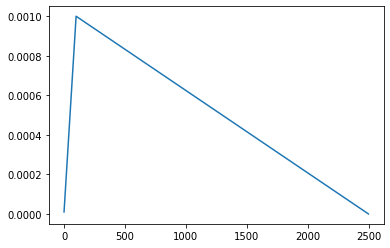

In [28]:
plt.plot(b)

In [17]:
torch.optim.lr_scheduler.LambdaLR(torch.optim.Adam(nn.Linear(1, 1).parameters()), )

In [ ]:
trainer.fit(
    model, datamodule=data_module
)

In [1]:
from collections import Counter